# Análise de Fake News

Exercício realizado para a disciplina de Big Data e Computaçãoem nuvem.

Objetivo:
* Encontrar padrões nas notícias brasileiras que permitam suspeitar de fake news.

Na base de dados __FakeBR Corpus__, disponível em `data/fakenews/full_texts`, extraída de  https://sites.google.com/icmc.usp.br/opinando/, existem duas pastas que separam conjuntos distintos de notícias:
* `fake`: com notícias sabidamente falsas;
* `true`: com notícias sabidamente verdadeiras.

In [4]:
datapath = '../data/fakenews/full_texts/'

In [5]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk
import wordcloud as wc
import seaborn as sns
import re

In [6]:
# criar uma sessão spark
spark = SparkSession.builder \
        .master('local[8]') \
        .appName('fakenews') \
        .getOrCreate()

In [8]:
sc = spark.sparkContext

In [9]:
stopwords = nltk.corpus.stopwords.words('portuguese')

In [10]:
parada = ['de','para','em','que','da','mas','na','nos','no','por','pelo','ao','rt','-','e','os','as','um','como','uma','já','oi','até','ele','ela','você','com','tem','aos','esse','essa','este','esta'
          'isso','isto','se','vai','ou','dos','das','sobre','está','também','muito','ainda','olá','às','nosso','estão','entre','foi','este',',','?','!',':',';','•','RT','@','-','*','$','(',')','%','\n',
         'te','pode','o','a','deve',' isso','sua','seu','nossa','mai','será','pra','vc',' olá','ola','r$','','após']

In [11]:
stopwords = stopwords + parada

## Frequência de cada palavra em relação ao total de palavras da base

In [12]:
def top_n_palavras(base, n, stopwords):
    
    base1 = base.map(lambda x: x[1])
    base2 = base1.map(lambda x: x.lower().replace('\n',' ') \
                                    .replace('\t','') \
                                    .replace('\r','') \
                                    .replace('\\x+[0-9]{2}','') \
                                    #.replace("x9*",' ') \
                                    .replace(',','') \
                                    .replace('.','') \
                                    .replace('?','') \
                                    .replace('!','') \
                                    .replace('"','') \
                                    #.replace('-',' ') \
                                    .replace(":",''))
    
    base3 = base2.map(lambda x: x.split(' '))
    base4 = base3.map(lambda x: (x[0],1))
    base5 = base4.filter(lambda x: x[0] not in stopwords)
    base6 = base5.reduceByKey(lambda x,y: x+y)
    
    #contagem do total de palavras da base
    word_counter = base3.map(lambda x: len(x[0]))
    word_count = word_counter.reduce(lambda x,y: x+y)
    
    base7 = base6.map(lambda x: (x[0],(x[1], x[1]/word_count)))
    
    top = base7.takeOrdered(n, lambda x: -x[1][1])
    
    return top
     

In [13]:
fake = sc.wholeTextFiles(datapath + '/fake/*.txt')

In [14]:
true = sc.wholeTextFiles(datapath + '/true/*.txt')

## Aplicando a função nas bases

In [15]:
top_fake = top_n_palavras(fake, 100, stopwords)

In [16]:
top_fake[:10]

[('lula', (97, 0.004574824317313588)),
 ('dilma', (69, 0.003254256473140593)),
 ('temer', (50, 0.002358156864594633)),
 ('urgente', (45, 0.0021223411781351696)),
 ('deputado', (44, 0.0020751780408432767)),
 ('jornalista', (40, 0.0018865254916757062)),
 ('coreia', (36, 0.0016978729425081356)),
 ('ministro', (35, 0.001650709805216243)),
 ('presidente', (29, 0.001367730981464887)),
 ('governo', (29, 0.001367730981464887))]

In [17]:
top_true = top_n_palavras(true, 100, stopwords)

In [18]:
top_true[:10]

[('temer', (60, 0.003251151449471688)),
 ('veja', (39, 0.0021132484421565972)),
 ('coreia', (39, 0.0021132484421565972)),
 ('lula', (38, 0.0020590625846654024)),
 ('segunda-feira', (36, 0.0019506908696830128)),
 ('retrospectiva', (35, 0.001896505012191818)),
 ('terça-feira', (35, 0.001896505012191818)),
 ('quarta-feira', (33, 0.0017881332972094284)),
 ('quinta-feira', (32, 0.0017339474397182336)),
 ('pf', (29, 0.0015713898672446492))]

## Diferença entre as frequências relativas

In [19]:
import pandas as pd
import numpy as np

In [20]:
t_df = pd.DataFrame(top_true, columns = ['word','count'])

In [21]:
t_df['pct'] = t_df['count'].str[1]

In [22]:
t_df.head()

,word,count,pct
0,temer,"(60, 0.003251151449471688)",0.003251
1,veja,"(39, 0.0021132484421565972)",0.002113
2,coreia,"(39, 0.0021132484421565972)",0.002113
3,lula,"(38, 0.0020590625846654024)",0.002059
4,segunda-feira,"(36, 0.0019506908696830128)",0.001951


In [23]:
f_df = pd.DataFrame(top_fake, columns = ['word','count'])

In [24]:
f_df

,word,count
0,lula,"(97, 0.004574824317313588)"
1,dilma,"(69, 0.003254256473140593)"
2,temer,"(50, 0.002358156864594633)"
3,urgente,"(45, 0.0021223411781351696)"
4,deputado,"(44, 0.0020751780408432767)"
...,...,...
95,brasília,"(5, 0.00023581568645946328)"
96,ministra,"(5, 0.00023581568645946328)"
97,maior,"(5, 0.00023581568645946328)"
98,assista,"(5, 0.00023581568645946328)"


In [25]:
f_df['pct'] = f_df['count'].str[1]

In [26]:
t_df.pct

0     0.003251
1     0.002113
2     0.002113
3     0.002059
4     0.001951
        ...   
95    0.000217
96    0.000217
97    0.000217
98    0.000217
99    0.000217
Name: pct, Length: 100, dtype: float64

In [27]:
f_df.pct

0     0.004575
1     0.003254
2     0.002358
3     0.002122
4     0.002075
        ...   
95    0.000236
96    0.000236
97    0.000236
98    0.000236
99    0.000236
Name: pct, Length: 100, dtype: float64

In [28]:
diff = (t_df.pct)*100 - (f_df.pct)*100

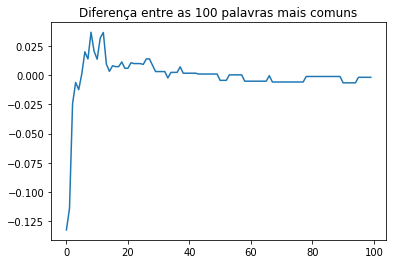

In [29]:
diff.plot(title = "Diferença entre as 100 palavras mais comuns")

## Gráficos

In [30]:
import matplotlib.pyplot as plt

In [37]:
word = [item[0] for item in top_true[:30]]
pct = [item[1][1]*100 for item in top_true[:30]]  

Text(0.5, 1.0, 'Top 20 palavras em notícias reais')

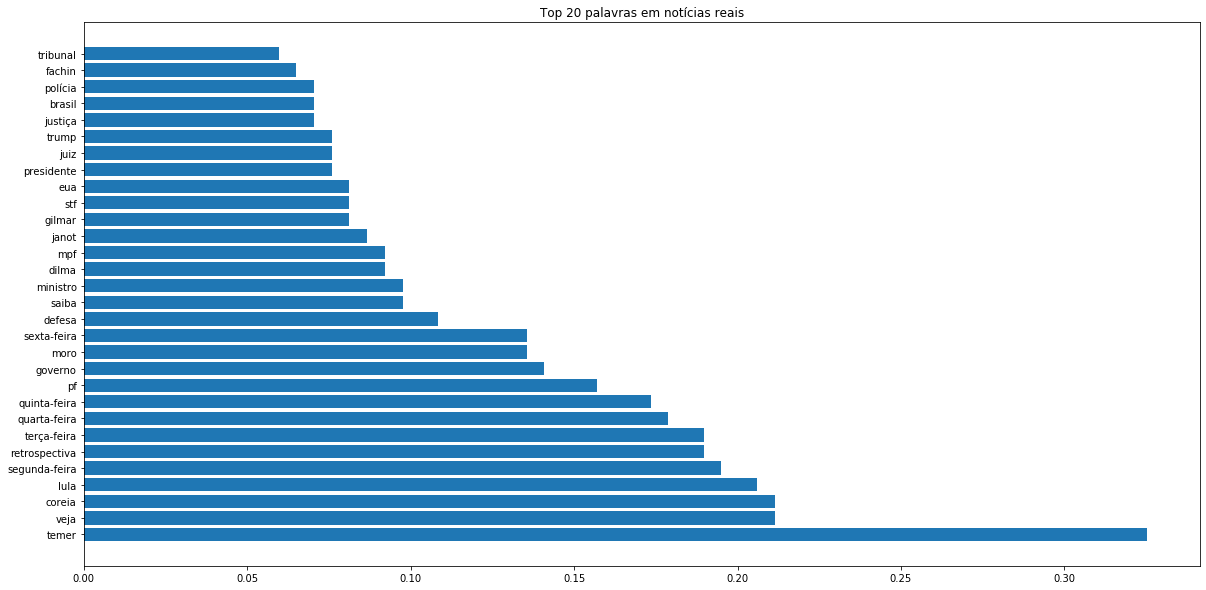

In [53]:
plt.figure(figsize=(20,10))
plt.barh(word, pct)
plt.title('Top 20 palavras em notícias reais')

In [51]:
word_f = [item[0] for item in top_fake[:30]]
pct_f = [item[1][1]*100 for item in top_fake[:30]] 

Text(0.5, 1.0, 'Top 20 palavras em Fake News')

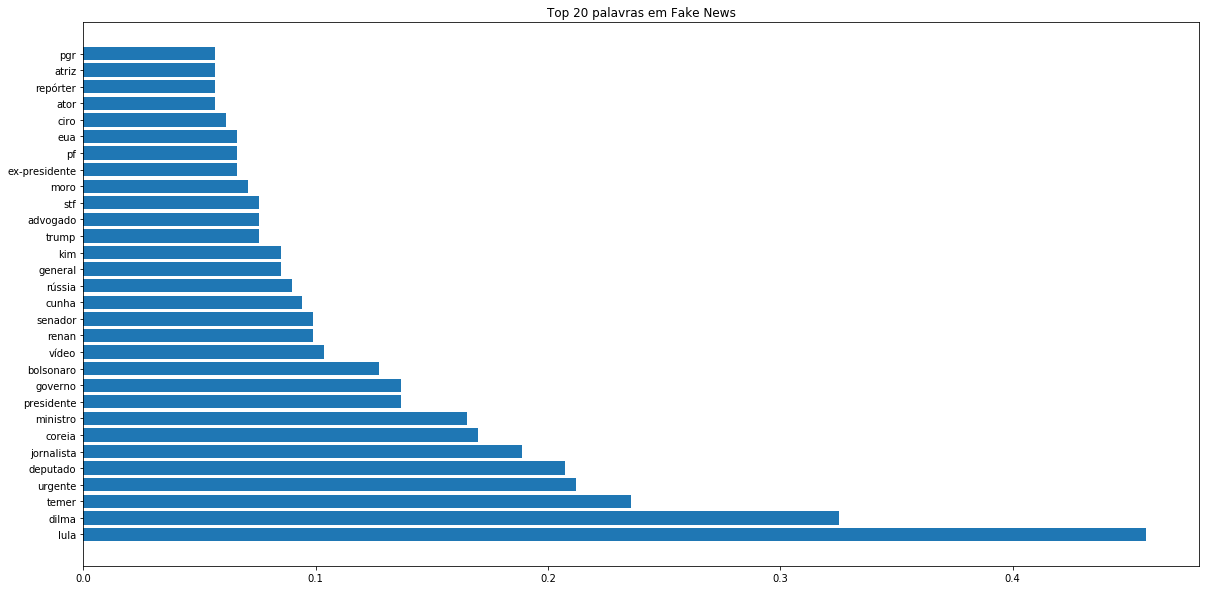

In [52]:
plt.figure(figsize=(20,10))
plt.barh(word_f, pct_f)
plt.title('Top 20 palavras em Fake News')

Nota-se que nas notícias reais os assuntos são mais bem distribuídos, enquanto as fake news focam a discussão em torno de Lula e Dilma. Além disso, em notícias reais, há menção recorrente de dias da semana, dando ao leitor uma ideia de "âncora temporal". Esta pode ser uma forma preliminar de diferenciar os dois tipos de notícias. Soma-se a isso o fato de siglas de órgãos ("pf","stf","mpf") serem possíveis referências às fontes das informações. Em ambas as bases, por outro lado, os nomes dos antigos presidentes e pessoas ligadas ao governo são recorrentes. Com essa breve análise, conclui-se que as notícias reais tendem a informar com mais precisão quando e de onde vieram as informações, enquanto as fake news apenas apontam pessoas de destaque político, mencionadas também nas notícias reais.

# Spark Stop

In [134]:
spark.stop()